Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 5709 files belonging to 9 classes.
Using 4568 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 5709 files belonging to 9 classes.
Using 1141 files for validation.


In [8]:
# Listing out all the classes of skin cancer in the dataset.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

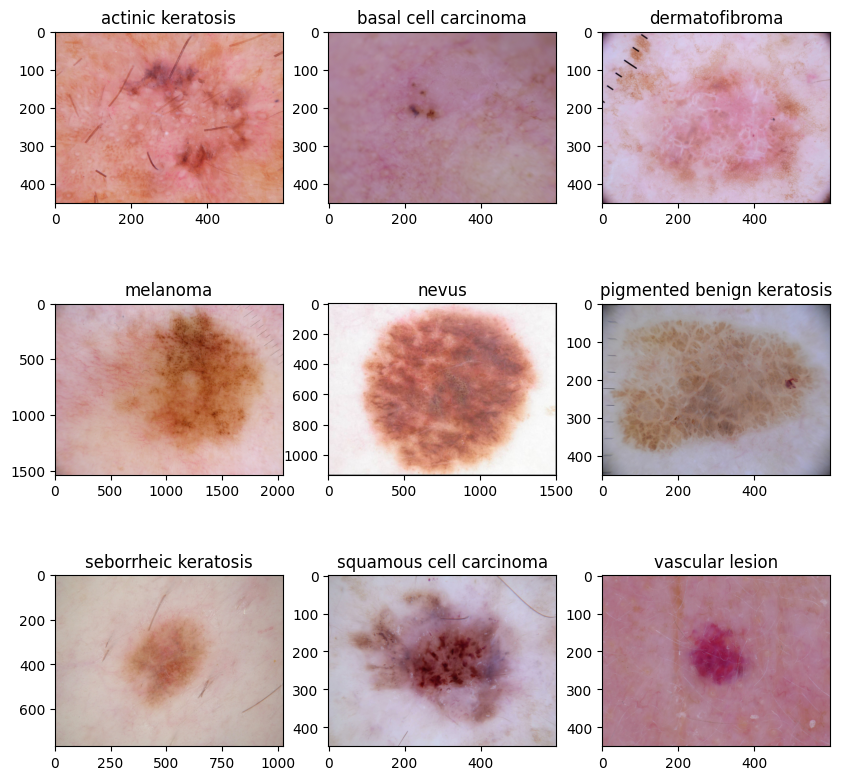

In [9]:
### visualisation
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[0])
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

## Model 1

In [11]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',  activation ='relu', input_shape = (180, 180, 32)),
                    Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',  activation ='relu'),
                    MaxPool2D(pool_size=(2,2)),
                    Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',  activation ='relu'),
                    MaxPool2D(pool_size=(2,2)),
                    Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',  activation ='relu'),
                    MaxPool2D(pool_size=(2,2)),
                    Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',  activation ='relu'),
                    MaxPool2D(pool_size=(2,2)),
                    Dropout(0.2),
                    Flatten(),
                    Dense(num_classes, activation = "softmax")
                    ])

## adding few convolutional layers followed by Maxpool layers and dropout layers to avoid overfitting

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                   

As we can see a total of 277129 trainable parameters.

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
143/143 [==============================] - 901s 2s/step - loss: 2.0974 - accuracy: 0.1550 - val_loss: 2.0980 - val_accuracy: 0.1586
Epoch 2/20
143/143 [==============================] - 13s 90ms/step - loss: 2.0772 - accuracy: 0.1743 - val_loss: 2.0941 - val_accuracy: 0.1613
Epoch 3/20
143/143 [==============================] - 13s 94ms/step - loss: 2.0680 - accuracy: 0.1613 - val_loss: 2.1003 - val_accuracy: 0.1315
Epoch 4/20
143/143 [==============================] - 13s 89ms/step - loss: 2.1004 - accuracy: 0.1705 - val_loss: 2.1010 - val_accuracy: 0.1586
Epoch 5/20
143/143 [==============================] - 13s 89ms/step - loss: 2.0649 - accuracy: 0.1677 - val_loss: 2.1029 - val_accuracy: 0.1613
Epoch 6/20
143/143 [==============================] - 13s 89ms/step - loss: 2.0640 - accuracy: 0.1690 - val_loss: 2.1272 - val_accuracy: 0.1709
Epoch 7/20
143/143 [==============================] - 13s 88ms/step - loss: 2.0569 - accuracy: 0.1780 - val_loss: 2.1048 - val_accuracy: 

### Visualizing training results

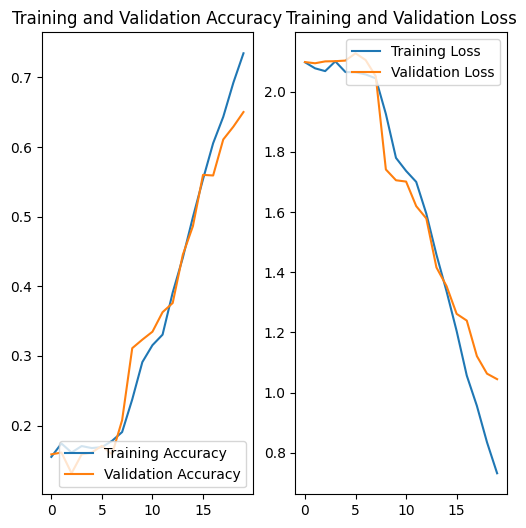

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings

We can see that the training accuracy is 0.73 but validation accuracy is only 0.65. We can infer that the difference between validation accuracy and training accuracy is not too much. This might be because we have used a dropout layer at the end which could have helped.

Trying Augmentation - Randomly rotating, zooming, fliping images. Lets check if the accuracy improves.

### Data Augmentation

In [16]:
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3),seed=100),
                             layers.experimental.preprocessing.RandomRotation(0.3, fill_mode='reflect',seed=100),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.1, 0.2), width_factor=(0.2, 0.2),seed=100, fill_mode='reflect')
])
## randomly rotating, flipping and zooming images

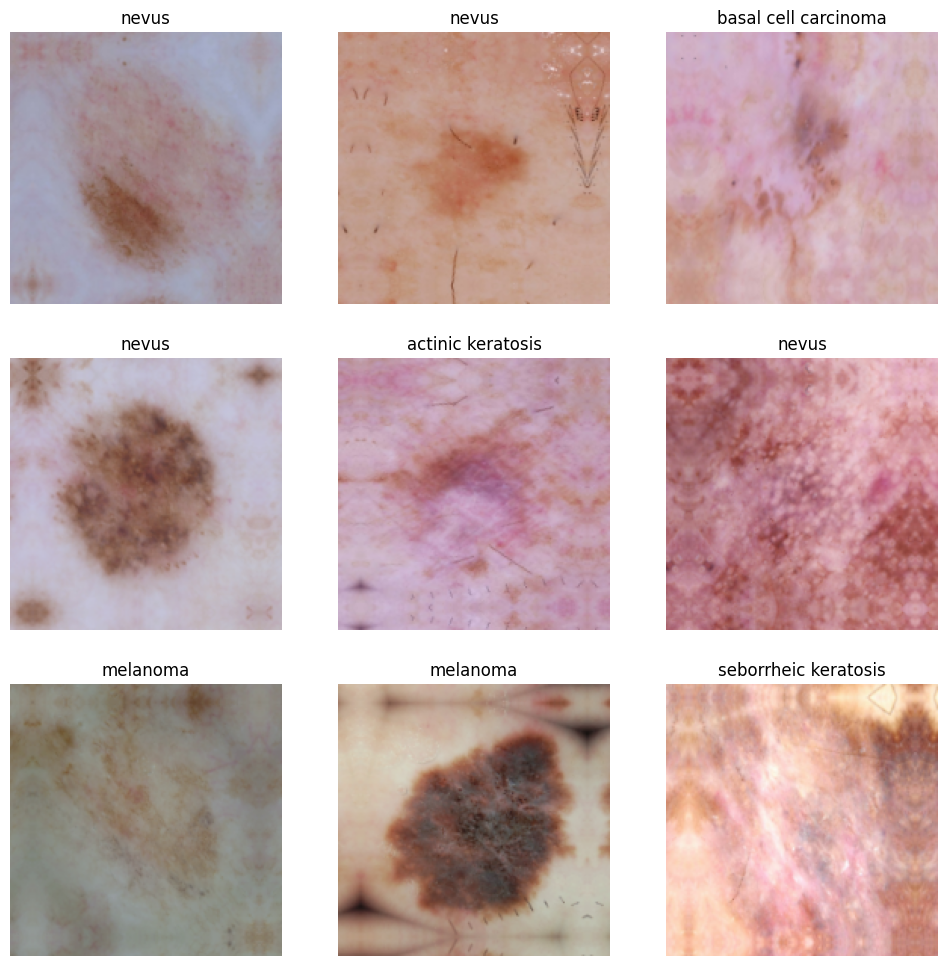

In [17]:
# printing augmented images
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model

## Model 2


In [18]:
num_classes = 9
model = Sequential([data_augument,
                    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',  activation ='relu', input_shape = (180, 180, 32)),
                    Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',  activation ='relu'),
                    MaxPool2D(pool_size=(2,2)),
                    Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',  activation ='relu'),
                    MaxPool2D(pool_size=(2,2)),
                    Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',  activation ='relu'),
                    MaxPool2D(pool_size=(2,2)),
                    Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',  activation ='relu'),
                    MaxPool2D(pool_size=(2,2)),
                    Dropout(0.2),
                    Flatten(),
                    Dense(num_classes, activation = "softmax")
                    ])

# building a model using the augmentated data

### Compiling the model

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

### Training the model

In [20]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
143/143 [==============================] - 16s 96ms/step - loss: 1.9925 - accuracy: 0.2312 - val_loss: 1.9094 - val_accuracy: 0.2533
Epoch 2/20
143/143 [==============================] - 13s 94ms/step - loss: 1.7710 - accuracy: 0.3115 - val_loss: 1.7332 - val_accuracy: 0.3252
Epoch 3/20
143/143 [==============================] - 13s 93ms/step - loss: 1.6664 - accuracy: 0.3516 - val_loss: 1.8534 - val_accuracy: 0.2498
Epoch 4/20
143/143 [==============================] - 13s 92ms/step - loss: 1.6496 - accuracy: 0.3619 - val_loss: 1.6257 - val_accuracy: 0.3462
Epoch 5/20
143/143 [==============================] - 13s 92ms/step - loss: 1.6117 - accuracy: 0.3722 - val_loss: 1.7635 - val_accuracy: 0.3181
Epoch 6/20
143/143 [==============================] - 13s 92ms/step - loss: 1.5977 - accuracy: 0.3792 - val_loss: 1.5920 - val_accuracy: 0.3550
Epoch 7/20
143/143 [==============================] - 13s 92ms/step - loss: 1.5463 - accuracy: 0.4030 - val_loss: 1.5416 - val_accuracy:

### Visualizing the results

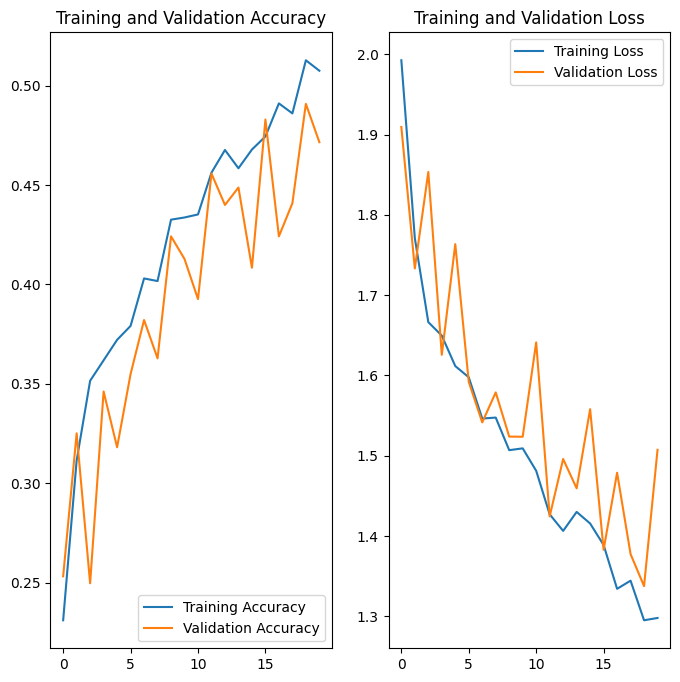

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings

We can see that the overall accuracy decreased but the difference betweeen validation and training accuracy also improved.

####  Find the distribution of classes in the training dataset.
####  Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

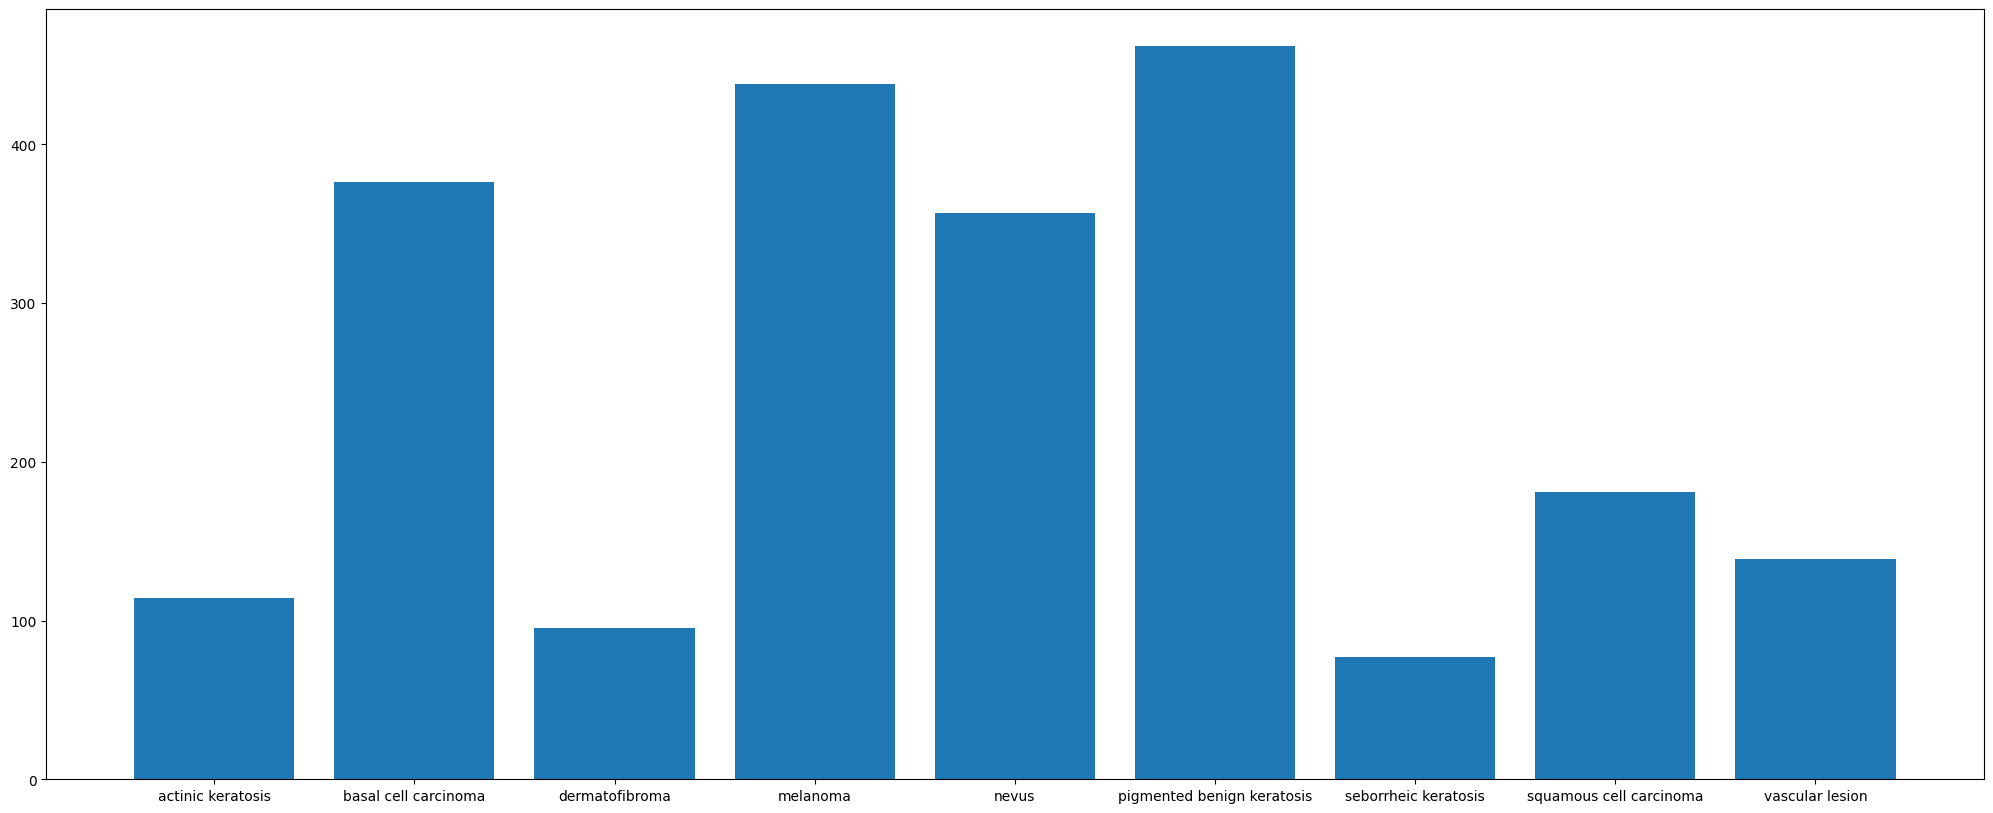

In [22]:
# appending the length of each directory into a list
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### - Which class has the least number of samples?
Pigmented benign keratosis has the most number of samples.
#### - Which classes dominate the data in terms proportionate number of samples?
seborrheic keratosis has the least samples.

This data imbalance in the number of samples may cause biased model and distorted results. Lets try and add more sample images to the dataset to handle this class imbalance.



#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [23]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [24]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)
### building a pipeline and pointing to the dataset path
### augmenting the data - rotating images by 10 degrees with a random probability of 70%
### generating 500 samples of each class

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B973D702D40>: 100%|██████████| 500/500 [00:22<00:00, 22.23 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B973D647730>: 100%|██████████| 500/500 [00:22<00:00, 22.24 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B973D9F70D0>: 100%|██████████| 500/500 [00:20<00:00, 24.00 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=965x649 at 0x7B97A01CA8F0>: 100%|██████████| 500/500 [01:20<00:00,  6.22 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7B973D7672B0>: 100%|██████████| 500/500 [01:25<00:00,  5.84 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B973D9F6800>: 100%|██████████| 500/500 [00:18<00:00, 27.06 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B973D764610>: 100%|██████████| 500/500 [00:42<00:00, 11.63 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B97AFF10B50>: 100%|██████████| 500/500 [00:18<00:00, 26.75 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B973D764610>: 100%|██████████| 500/500 [00:20<00:00, 24.65 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [25]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

7970


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Now lets train the model on the data created using Augmentor

In [27]:
batch_size = 32
img_height = 180
img_width = 180

In [28]:
data_dir_train="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10209 files belonging to 9 classes.
Using 8168 files for training.


In [29]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10209 files belonging to 9 classes.
Using 2041 files for validation.


## Model 3

In [30]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([data_augument,
                    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',  activation ='relu', input_shape = (180, 180, 32)),
                    Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',  activation ='relu'),
                    MaxPool2D(pool_size=(2,2)),
                    Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',  activation ='relu'),
                    MaxPool2D(pool_size=(2,2)),
                    Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',  activation ='relu'),
                    MaxPool2D(pool_size=(2,2)),
                    Dropout(0.2),
                    Flatten(),
                    Dense(num_classes, activation = "softmax")
                    ])

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [32]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
256/256 [==============================] - 89s 305ms/step - loss: 1.9949 - accuracy: 0.2244 - val_loss: 1.8437 - val_accuracy: 0.2959
Epoch 2/30
256/256 [==============================] - 75s 289ms/step - loss: 1.7471 - accuracy: 0.3145 - val_loss: 1.7218 - val_accuracy: 0.3542
Epoch 3/30
256/256 [==============================] - 68s 260ms/step - loss: 1.6630 - accuracy: 0.3461 - val_loss: 1.6507 - val_accuracy: 0.3689
Epoch 4/30
256/256 [==============================] - 77s 296ms/step - loss: 1.6031 - accuracy: 0.3738 - val_loss: 1.6092 - val_accuracy: 0.3768
Epoch 5/30
256/256 [==============================] - 67s 259ms/step - loss: 1.5504 - accuracy: 0.4014 - val_loss: 1.6884 - val_accuracy: 0.3866
Epoch 6/30
256/256 [==============================] - 66s 249ms/step - loss: 1.5174 - accuracy: 0.4123 - val_loss: 1.6332 - val_accuracy: 0.4096
Epoch 7/30
256/256 [==============================] - 63s 242ms/step - loss: 1.4689 - accuracy: 0.4310 - val_loss: 1.4435 - val_ac

####  Visualize the model results

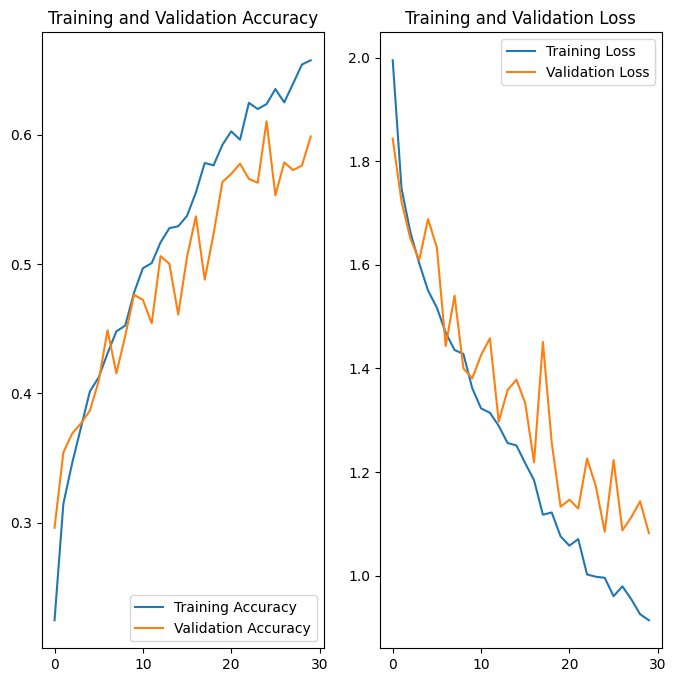

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Did class rebalance help?

The overall accuracy seemed to improve only a little from 0.50 to 0.65 training accuracy. Adding augmented data only improved a little accuracy. Since we did not change the structure or any other parameters in the model, lets try to create a different model on thsi augmented data and check the accuracy.

## Model 4

In [34]:
num_classes = 9
model = Sequential([data_augument,
                    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',  activation ='relu', input_shape = (180, 180, 32)),
                    Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',  activation ='relu'),
                    MaxPool2D(pool_size=(2,2)),
                     Dropout(0.2),
                    Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',  activation ='relu'),
                    MaxPool2D(pool_size=(2,2)),
                     Dropout(0.2),
                    Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',  activation ='relu'),
                    MaxPool2D(pool_size=(2,2)),
                    Dropout(0.2),
                    Flatten(),
                    Dense(num_classes, activation = "softmax")
                    ])

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [36]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
256/256 [==============================] - 73s 271ms/step - loss: 2.1755 - accuracy: 0.1535 - val_loss: 2.1657 - val_accuracy: 0.1151
Epoch 2/20
256/256 [==============================] - 66s 253ms/step - loss: 2.1195 - accuracy: 0.1967 - val_loss: 2.0606 - val_accuracy: 0.1886
Epoch 3/20
256/256 [==============================] - 65s 250ms/step - loss: 1.8979 - accuracy: 0.2707 - val_loss: 1.7439 - val_accuracy: 0.3116
Epoch 4/20
256/256 [==============================] - 77s 298ms/step - loss: 1.6994 - accuracy: 0.3415 - val_loss: 1.6426 - val_accuracy: 0.3459
Epoch 5/20
256/256 [==============================] - 68s 260ms/step - loss: 2.0274 - accuracy: 0.2269 - val_loss: 2.1591 - val_accuracy: 0.1426
Epoch 6/20
256/256 [==============================] - 65s 249ms/step - loss: 2.1642 - accuracy: 0.1370 - val_loss: 2.1585 - val_accuracy: 0.1489
Epoch 7/20
256/256 [==============================] - 77s 296ms/step - loss: 2.1801 - accuracy: 0.1420 - val_loss: 2.1589 - val_ac

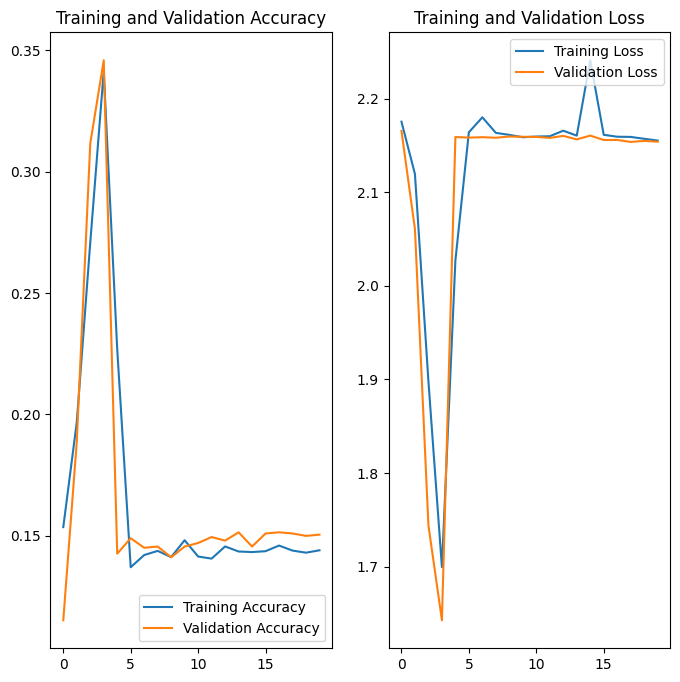

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can see that the accuracy dropped drastically. this might be because we have used 3 drop out layers which might have led to a underfitted model. 


Out of the 4 models the simplest model - model 1 has the best accuracy and model 2 with randomly augmented data has the lowest difference in accuracy between validation data and training data. If we have tried with more epochs on model 2, it might have led to better results.